### Winning solution of the Data Science Olympics 2019

In [4]:
import pandas as pd
import numpy as np
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('display.max_columns', 9999)
pd.set_option('display.max_rows', 200)

np.random.seed(6)

In [5]:
# Define the competition scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)

# Load data

In [6]:
# Load train
train = pd.read_csv(filepath_or_buffer='data/train_requests.csv',
                    sep=',',
                    low_memory=False,
                    error_bad_lines=False,
                    index_col=0)
# Load test
test = pd.read_csv(filepath_or_buffer='data/test_requests.csv',
                   sep=',',
                   low_memory=False,
                   error_bad_lines=False,
                   index_col=0)

# Rename target
train.rename(columns={'granted_number_of_nights': 'target'},
             inplace=True)

# Create target in test df before train+test concatenation
test['target'] = np.nan

# Create train/test variable before train+test concatenation
train['train'] = 1
test['train'] = 0

b'Skipping line 31303: expected 24 fields, saw 49\nSkipping line 75954: expected 24 fields, saw 49\n'


In [7]:
train.head(2)

,animal_presence,answer_creation_date,child_situation,child_to_come,district,target,group_composition_id,group_composition_label,group_creation_date,group_id,group_main_requester_id,group_type,housing_situation_id,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type,train
request_id,,,,,,,,,,,,,,,,,,,,,,,,
130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,c62f692dcc3f31880dd3937369c6f9e1,56252a8182a732cad0d106328bf96a0b,individual,160,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN,1
b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,cbb3ae0239a3ca9a0441831bde02aaa3,b23d21c9973e5b74504a94eebe82fb75,individual,160,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN,1


/anaconda3/envs/conda_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


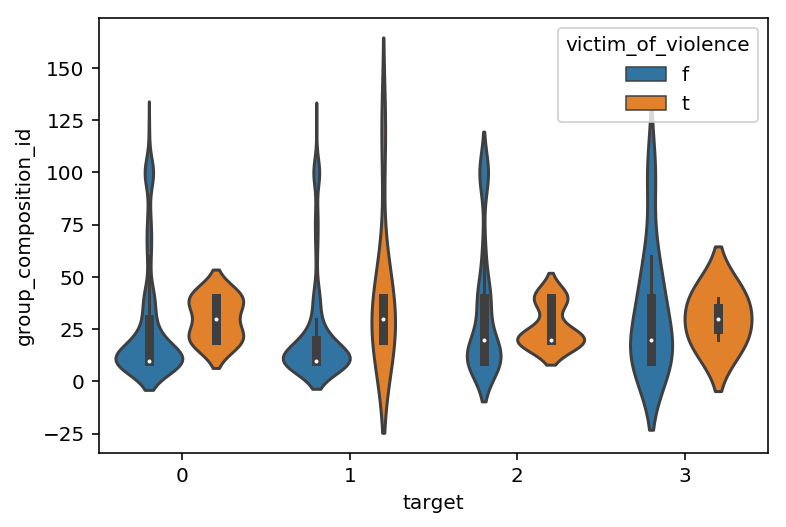

In [8]:
sns.violinplot(x='target', y='group_composition_id', hue='victim_of_violence', data=train.iloc[:2000,:]);

# Feature engineering

In [37]:
# concatenation train+test
df = pd.concat((train[train.columns], test[train.columns]), axis=0)

In [38]:
# list categorical features
categorical_features = ['animal_presence',
                        'child_to_come',
                        'group_composition_label',
                        'group_id',
                        'group_main_requester_id',
                        'group_type',
                        'housing_situation_label',
                        'long_term_housing_request',
                        'request_backoffice_creator_id',
                        'requester_type',
                        'social_situation_id',
                        'town',
                        'victim_of_violence',
                        'victim_of_violence_type',
                        'district']

In [39]:
# label encoding
for var in categorical_features:
    encoder = LabelEncoder()
    df['le_{}'.format(var)] = encoder.fit_transform(df[var].astype(str))
    df.loc[df[var].isnull(), 'le_{}'.format(var)] = -1

In [40]:
# value counts (add number of occurence of each modality)
for var in categorical_features:
    mapping_vc = df[var].value_counts()
    df['vc_{}'.format(var)] = df[var].map(mapping_vc)

In [41]:
# date features
def create_date_features(df, column):
    df[column] = pd.to_datetime(df[column])
    df['day_{}'.format(column)] = df[column].dt.day
    df['week_{}'.format(column)] = df[column].dt.week
    df['month_{}'.format(column)] = df[column].dt.month
    df['year_{}'.format(column)] = df[column].dt.year
    df['hour_{}'.format(column)] = df[column].dt.hour
    df['weekday_{}'.format(column)] = df[column].dt.weekday
    df['numeric_{}'.format(column)] = df[column].astype(np.int64) * 1e-9
    return df

for date_col in ['answer_creation_date', 'group_creation_date', 'request_creation_date']:
    df[date_col] = create_date_features(df, date_col)
    df.drop(date_col, axis=1, inplace=True)

df['diff_date_1'] = df['numeric_request_creation_date'] - df['numeric_group_creation_date']
df['diff_date_2'] = df['numeric_answer_creation_date'] - df['numeric_group_creation_date']
df['diff_date_3'] = df['numeric_answer_creation_date'] - df['numeric_request_creation_date']

In [54]:
# target encoding
def target_encoding(df, grp_col, target_col, n_folds=10):
    df['fold'] = np.random.randint(n_folds, size=len(df))
    df_te = pd.DataFrame()
    for fold in df['fold'].unique():
        df_fold = df[df['fold'] != fold].groupby(grp_col)[target_col].agg(['mean', 'count'])
        df_fold['fold'] = fold
        df_te = df_te.append(df_fold.reset_index())
    df_te.rename(columns={'mean': 'te_mean_{}'.format('_'.join(grp_col)),
                          'count': 'te_count_{}'.format('_'.join(grp_col))},
                 inplace=True)
    df = pd.merge(df, df_te, how='left')
    df.drop('fold', axis=1, inplace=True)
    return df

te_grp_cols = [['group_id'],
               ['group_main_requester_id'],
               ['request_backoffice_creator_id'],
               ['social_situation_id'],
               ['housing_situation_id'],
               ['district'],
               ['town'],
               ['social_situation_id', 'group_main_requester_id'],
               ['social_situation_id', 'group_id'],
               ['social_situation_id', 'request_backoffice_creator_id'],
               ['group_main_requester_id', 'group_id'],
               ['group_main_requester_id', 'request_backoffice_creator_id'],
               ['group_id', 'request_backoffice_creator_id'],
               ['social_situation_id', 'housing_situation_id'],
               ['group_main_requester_id', 'housing_situation_id'],
               ['group_id', 'housing_situation_id'],
               ['request_backoffice_creator_id', 'housing_situation_id']]

for grp_col in te_grp_cols:
    df = target_encoding(df=df, grp_col=grp_col, target_col='target', n_folds=10)

In [55]:
df.sample()

,animal_presence,child_situation,child_to_come,district,target,group_composition_id,group_composition_label,group_id,group_main_requester_id,group_type,housing_situation_id,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type,train,le_animal_presence,le_child_to_come,le_group_composition_label,le_group_id,le_group_main_requester_id,le_group_type,le_housing_situation_label,le_long_term_housing_request,le_request_backoffice_creator_id,le_requester_type,le_social_situation_id,le_town,le_victim_of_violence,le_victim_of_violence_type,le_district,vc_animal_presence,vc_child_to_come,vc_group_composition_label,vc_group_id,vc_group_main_requester_id,vc_group_type,vc_housing_situation_label,vc_long_term_housing_request,vc_request_backoffice_creator_id,vc_requester_type,vc_social_situation_id,vc_town,vc_victim_of_violence,vc_victim_of_violence_type,vc_district,day_answer_creation_date,week_answer_creation_date,month_answer_creation_date,year_answer_creation_date,hour_answer_creation_date,weekday_answer_creation_date,numeric_answer_creation_date,day_group_creation_date,week_group_creation_date,month_group_creation_date,year_group_creation_date,hour_group_creation_date,weekday_group_creation_date,numeric_group_creation_date,day_request_creation_date,week_request_creation_date,month_request_creation_date,year_request_creation_date,hour_request_creation_date,weekday_request_creation_date,numeric_request_creation_date,diff_date_1,diff_date_2,diff_date_3,te_mean_group_id,te_count_group_id,te_mean_group_main_requester_id,te_count_group_main_requester_id,te_mean_request_backoffice_creator_id,te_count_request_backoffice_creator_id,te_mean_social_situation_id,te_count_social_situation_id,te_mean_housing_situation_id,te_count_housing_situation_id,te_mean_district,te_count_district,te_mean_town,te_count_town,te_mean_social_situation_id_group_main_requester_id,te_count_social_situation_id_group_main_requester_id,te_mean_social_situation_id_group_id,te_count_social_situation_id_group_id,te_mean_social_situation_id_request_backoffice_creator_id,te_count_social_situation_id_request_backoffice_creator_id,te_mean_group_main_requester_id_group_id,te_count_group_main_requester_id_group_id,te_mean_group_main_requester_id_request_backoffice_creator_id,te_count_group_main_requester_id_request_backoffice_creator_id,te_mean_group_id_request_backoffice_creator_id,te_count_group_id_request_backoffice_creator_id,te_mean_social_situation_id_housing_situation_id,te_count_social_situation_id_housing_situation_id,te_mean_group_main_requester_id_housing_situation_id,te_count_group_main_requester_id_housing_situation_id,te_mean_group_id_housing_situation_id,te_count_group_id_housing_situation_id,te_mean_request_backoffice_creator_id_housing_situation_id,te_count_request_backoffice_creator_id_housing_situation_id
210375,f,-1,NaN,60,0.0,10,man alone,81f8e1cca8e19dd17143513fd44d070c,a14816402d82861e3a93c39be1f7949a,individual,200,street,NaN,-1,5072b10fb7d333360cf7f2f1d6d0c8a9,user,284de38bc04aade951662de4be0a48a9,NaN,f,NaN,1,0,-1,7,35279,42376,1,21,-1,352,2,10959,-1,0,-1,62,370913,NaN,203901.0,40,40,267222.0,158910.0,NaN,1520,366573,40,NaN,365223.0,NaN,15039,3,1,1,2019,16,3,1.546534e+09,6.0,49.0,12.0,2018.0,15.0,3.0,1.544109e+09,3,1,1,2019,16,3,1.546534e+09,2424631.955,2424631.955,0.0,0.0,19.0,0.0,23.0,0.010176,1081.0,0.0,24.0,0.376949,114668,0.090808,10836.0,NaN,NaN,0.0,23.0,0.0,20.0,0.0,2.0,0.0,21.0,0.0,3.0,0.0,3.0,0.0,22.0,0.0,23.0,0.0,21.0,0.008612,1045.0


In [ ]:
feat cst ?

# Create X & X_test

In [56]:
def select_features_by_type(df, type_list):
    dtypes = df.dtypes.map(str)
    return list(dtypes[dtypes.isin(type_list)].index)
    
numerical_features = select_features_by_type(df, ['int64','float64'])

In [57]:
X_full = df[numerical_features].copy()

X = X_full[X_full['train'] == 1].copy()
X_test = X_full[X_full['train'] == 0].copy()
y = X_full[X_full['train'] == 1]['target']

X.drop(['target', 'train'], axis=1, inplace=True)
X_test.drop(['target', 'train'], axis=1, inplace=True)

# CV

In [61]:
lgb = LGBMClassifier(nthread=8,
                     objective='logloss',
                     n_estimators=1000,
                     num_leaves=45,
                     learning_rate=0.03,
                     subsample=1.0,
                     subsample_freq=1,
                     colsample_bytree=0.3,
                     min_child_samples=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)],
        early_stopping_rounds=100,
        sample_weight=10**y_train,
        verbose=50,
        eval_sample_weight=[10**y_val]); # this is to add weight and change cost in evaluation

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's multi_logloss: 0.590652
[100]	valid_0's multi_logloss: 0.496466
[150]	valid_0's multi_logloss: 0.461663
[200]	valid_0's multi_logloss: 0.446782
[250]	valid_0's multi_logloss: 0.441444
[300]	valid_0's multi_logloss: 0.439288
[350]	valid_0's multi_logloss: 0.44028
[400]	valid_0's multi_logloss: 0.441967
Early stopping, best iteration is:
[301]	valid_0's multi_logloss: 0.439287


In [62]:
competition_scorer(y_val, lgb.predict_proba(X_val))

0.43928728845767034

In [63]:
lgb.n_estimators = lgb.best_iteration_

# Fit & Predict

In [64]:
lgb.fit(X, y, sample_weight=10**y)
preds = lgb.predict_proba(X_test)

df_pred = pd.concat([pd.DataFrame(test.index), pd.DataFrame(preds)], axis=1)

/anaconda3/envs/conda_py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/conda_py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


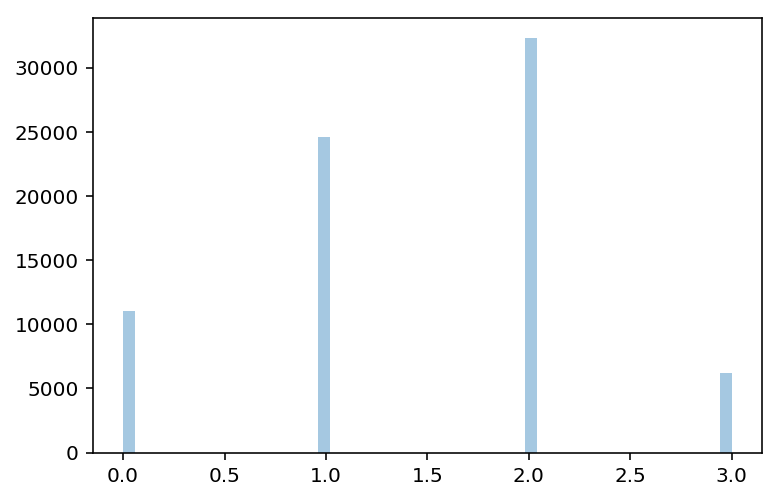

In [65]:
sns.distplot(np.argmax(preds, axis=1), kde=False);

# Submit

In [66]:
# https://qscore.datascience-olympics.com/
import io, math, requests

def submit_prediction(df, sep=',', comment='', compression='gzip', **kwargs):
    TOKEN='c7fba9819cad6ed56b0d43f38309ebd676b2a50ebe849cbc5520f6e64d47a065dfbe0ca59e6300b542b091ba7fbdbe134b8fbceafd746d0fd7fa47300f3b9733'
    URL='https://qscore.datascience-olympics.com/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

submit_prediction(df_pred, sep=',', index=False, comment='my submission')

### What didn’t work
- Random forest: do not directly optimize log loss, too weak compared to LightGBM
- Neural nets: too slow, no time to tune the net architecture, no GPU :(
- Blend of several LightGBM (with seed variation): surprisingly it didn’t work on this dataset